In [226]:
%matplotlib inline

import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

from sotodlib import core
from sotodlib.core.metadata import ManifestDb, load_metadata
import sotodlib.io.load_book as lb

from optical_loading import pwv_interp, get_fpa_temps, UXM_dict, add_iv_info

import dill as pk
import os
import glob
import h5py

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [227]:
#lat_baseline = core.AxisManager.load("v3r7_baseline_pwv_el_sweep_LAT.h5")
#lat_goal = core.AxisManager.load("v3r7_goal_pwv_el_sweep_LAT.h5")
#edx = np.where( np.isclose(lat_goal.elevations,50) )[0][0]

In [228]:
with open("opt_load_det.pk", "rb") as f:
    optical_loading_detectors = pk.load(f)
det_match_path = "/so/home/mrandall/Analysis/Detmatching/Matched_Dark_Cal/lat/"
detmatches = glob.glob(det_match_path + "*.h5")

In [229]:
## context for loading data
ctx = core.Context('/so/metadata/lat/contexts/smurf_detsets.yaml')


In [291]:
ufm = "mv11"

if "uv" in ufm:
    ufm_type="UHF"
    ufm_1 = "UHF_1"
    ufm_2 = "UHF_2"
    low_freq = "220"
    high_freq = "280"

elif "mv" in ufm:
    ufm_type="MF"
    ufm_1 = "MF_1"
    ufm_2 = "MF_2"
    low_freq = "090"
    high_freq = "150"

else:
    ufm_type="LF"
    ufm_1 = "LF_1"
    ufm_2 = "LF_2"
    low_freq = "030"
    high_freq = "040"

start = dt.datetime(2025,4,17, tzinfo=dt.timezone.utc)
end = dt.datetime(2025,5,5, tzinfo=dt.timezone.utc)
obs_list = ctx.obsdb.query(
    f"{end.timestamp()} > timestamp and timestamp > {start.timestamp()} and type=='oper' and subtype=='iv'"
    " and stream_ids_list == 'ufm_{}'".format(ufm)
)


In [292]:
obs_list

ResultSet<[obs_id,timestamp,start_time,stop_time,n_samples,telescope,telescope_flavor,tube_slot,tube_flavor,type,subtype,wafer_count,detector_flavor,duration,az_center,az_throw,el_center,el_throw,roll_center,roll_throw,wafer_slots_list,stream_ids_list], 168 rows>

In [293]:
## from above, I know obs_list has only one stream_id in it

singles = []
obs_start = 0
obs_end = len(obs_list)
for i in range(obs_start,obs_end):
    obs = obs_list[i]
    meta = ctx.get_meta(obs)
    try:
        add_iv_info(meta, ctx)
        singles.append(meta)
    except FileNotFoundError:
        print(meta.obs_info.obs_id)
x = [m.dets.count for m in singles]
flags = np.array([i for i, l in enumerate(x) if l == min(x)])
x = np.array(x)[flags]
singles = np.array(singles)[flags]
obs_list = np.array(obs_list)[flags] 
assert min(x) == max(x), "Need to add some additional checks if channel counts are changing"

In [294]:
iv_fname = "./ivs/all_ivs_{}.h5".format(ufm)
obs_fname = "./ivs/obs_info_{}.h5".format(ufm)
if os.path.exists(iv_fname) and os.path.exists(obs_fname):
    with open(iv_fname, "wb") as f:
        all_iv_data = core.AxisManager.load(iv_fname)
    with open(obs_fname, "wb") as f:
        obs_info = core.AxisManager.load(obs_fname)

else:

    all_iv_data = core.AxisManager(
        singles[0].dets,
        core.IndexAxis('obs', len(singles)),
    )

    pwv = pwv_interp()

    obs_info = core.AxisManager(all_iv_data.obs)
    for f in singles[0].obs_info._fields.keys():
        if f == 'end_time':
            continue
        else:
            obs_info.wrap_new( f, ('obs',), dtype=type(singles[0].obs_info[f]))

    #Add pwv
    obs_info.wrap_new("pwv", ('obs',), dtype=float)
    obs_info.wrap_new("ufm_temp", ('obs',), dtype=float)

    fpa_temps = get_fpa_temps(obs_list[obs_start:obs_end])

    for m, meta in enumerate(singles):
        for f in singles[0].obs_info._fields.keys():
            if f=='end_time':
                continue
            obs_info[f][m] = meta.obs_info[f]
        obs_info["pwv"][m] = pwv((obs_info["start_time"][m] + obs_info["stop_time"][m])/2)
        obs_info["ufm_temp"][m] = fpa_temps[m]

    all_iv_data.wrap('obs_info', obs_info)
    all_iv_data.wrap('det_info', singles[0].det_info)
    # don't have a focal plane yet
    #all_iv_data.wrap('focal_plane', singles[0].focal_plane)

    iv_data = core.AxisManager( all_iv_data.dets, all_iv_data.obs)
    for f in singles[0].iv._fields.keys():
        iv_data.wrap_new(f, ('dets','obs'), dtype=singles[0].iv[f].dtype)
        iv_data[f] *= np.nan

    for m, meta in enumerate(singles):
        for f in singles[0].iv._fields.keys():
            iv_data[f][:,m] = meta.iv[f][:]
    all_iv_data.wrap('iv', iv_data)

    all_iv_data.obs_info.move("detector_flavor", new_name=None)

    #all_iv_data.save(iv_fname, overwrite=True)
    #obs_info.save(obs_fname, overwrite=True)

In [295]:
#for detmatch in detmatches:
#    if ufm in detmatch:
#        detmatch = h5py.File(detmatch, 'r')
#        break

In [296]:
lopts_low = []
lopts_high = []
for i, psat in enumerate(all_iv_data.iv.p_sat):
    if meta.iv.bgmap[i] in [0,1,4,5,8,9]:
        freq = "low"
    else:
        freq = "high"
    n = UXM_dict[freq][ufm]["n"]
    lopt = UXM_dict[freq][ufm]["psat_dark"]- psat + UXM_dict[freq][ufm]["kappa"]*(0.1**n - obs_info.ufm_temp**n)
    
    if all([np.isnan(item) for item in lopt]):
        continue
    
    if meta.iv.bgmap[i] in [0,1,4,5,8,9]:
        lopts_low.append(lopt)
    elif meta.iv.bgmap[i] in [2,3,6,7,10,11]:
        lopts_high.append(lopt)
lopts_low = np.array(lopts_low, dtype=float)
lopts_high = np.array(lopts_high, dtype=float)

flags_low = [] #Flag out obs that are entirely nan
               #This is surprisingly tricky using np funcs
for i in range(lopts_low.shape[1]):
    if not np.isnan(lopts_low.T[i]).all():
        flags_low.append(i)
flags_low = np.array(flags_low)

flags_high = []
for i in range(lopts_high.shape[1]):
    if not np.isnan(lopts_high.T[i]).all():
        flags_high.append(i)
flags_high = np.array(flags_high)

lopts_low = lopts_low[...,flags_low]
lopts_high = lopts_high[...,flags_high]

In [297]:
idx_dict = {"030": 0, "040":1, "090": 2, "150": 3, "220": 4, "280": 5}

In [298]:
saturated = np.zeros(len(all_iv_data.iv.p_sat.T))
for i, obs in enumerate(all_iv_data.iv.p_sat.T):
    saturated[i] = len(np.where((obs <= 0.1))[0]) + sum(np.isnan(x) for x in obs)
    



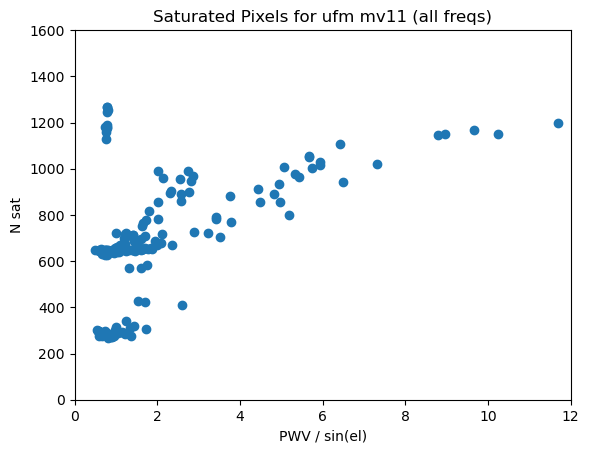

In [299]:
plt.scatter(obs_info.pwv/np.sin(obs_info.el_center* np.pi / 180.), saturated)
plt.title("Saturated Pixels for ufm {} (all freqs)".format(ufm))

plt.xlabel("PWV / sin(el)")
plt.ylabel("N sat")

plt.xlim(0, 12)
plt.ylim(0, 1600)

plt.savefig("./plts/sats/sat_{}.pdf".format(ufm), dpi=600)
plt.savefig("./plts/sats/sat_{}.png".format(ufm), dpi=600)

(0.0, 1600.0)

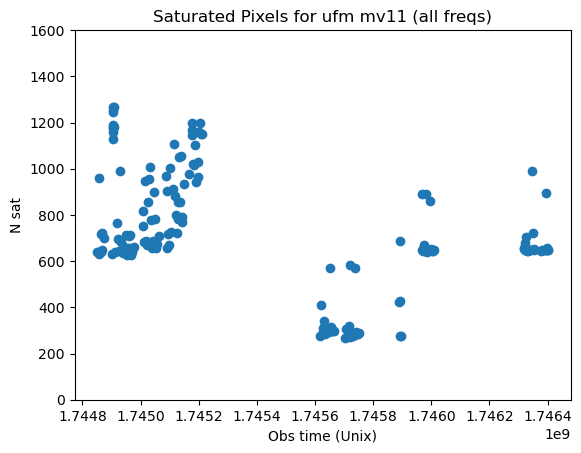

In [300]:
plt.scatter(obs_info.timestamp, saturated)
plt.title("Saturated Pixels for ufm {} (all freqs)".format(ufm))

plt.xlabel("Obs time (Unix)")
plt.ylabel("N sat")

#plt.xlim(0, 12)
plt.ylim(0, 1600)



## Fit data

In [301]:
fname = "lopt_fits.pk"
if os.path.exists(fname):
    with open(fname, "rb") as f:
        lopt_fit_dict = pk.load(f)
else:
    lopt_fit_dict = {}
    
from scipy.optimize import curve_fit

In [302]:
def func(x, L0, Lwet):
    return L0 + Lwet * x

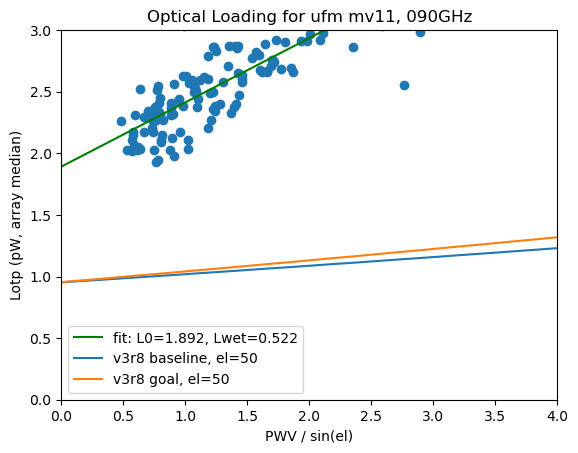

In [303]:
xdata, ydata = obs_info.pwv[flags_low]/np.sin(obs_info.el_center[flags_low]* np.pi / 180.), np.nanmedian(lopts_low, axis = 0)

pwvcut = np.where((xdata <= 3.0) & (0<ydata))

xdata = xdata[pwvcut]
ydata = ydata[pwvcut]

popt, pcov = curve_fit(func, xdata, ydata)

lopt_fit_dict[ufm] = {low_freq:{}}
lopt_fit_dict[ufm][low_freq]["popt"] = popt
lopt_fit_dict[ufm][low_freq]["pcov"] = pcov

plt.plot(optical_loading_detectors["pwv_sin_el"], func(optical_loading_detectors["pwv_sin_el"], *popt), 'g',label='fit: L0=%5.3f, Lwet=%5.3f' % tuple(popt))
plt.scatter(xdata, ydata)

plt.plot(optical_loading_detectors["pwv_sin_el"], 1e12*optical_loading_detectors["baseline"][ufm_type][ufm_1], label="v3r8 baseline, el=50")
plt.plot(optical_loading_detectors["pwv_sin_el"], 1e12*optical_loading_detectors["goal"][ufm_type][ufm_1], label="v3r8 goal, el=50")

plt.xlabel("PWV / sin(el)")
plt.ylabel("Lotp (pW, array median)")

plt.title("Optical Loading for ufm {}, {}GHz".format(ufm, low_freq))

plt.xlim(0,4)

if low_freq == "090":
    plt.ylim(0,3)
elif low_freq == "220":
    plt.ylim(0, 25)

plt.legend()
plt.savefig("./plts/lopts/lopt_{}_{}.pdf".format(ufm, low_freq), dpi=600)
plt.savefig("./plts/lopts/lopt_{}_{}.png".format(ufm, low_freq), dpi=600)

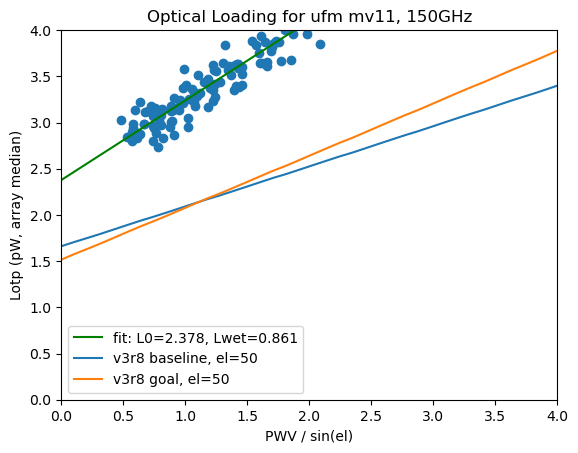

In [304]:
xdata, ydata = obs_info.pwv[flags_high]/np.sin(obs_info.el_center[flags_high]* np.pi / 180.), np.nanmedian(lopts_high, axis = 0)

pwvcut = np.where((xdata <= 3.0) & (0<ydata))

xdata = xdata[pwvcut]
ydata = ydata[pwvcut]

popt, pcov = curve_fit(func, xdata, ydata)

lopt_fit_dict[ufm] = {high_freq:{}}
lopt_fit_dict[ufm][high_freq]["popt"] = popt
lopt_fit_dict[ufm][high_freq]["pcov"] = pcov

plt.plot(optical_loading_detectors["pwv_sin_el"], func(optical_loading_detectors["pwv_sin_el"], *popt), 'g',label='fit: L0=%5.3f, Lwet=%5.3f' % tuple(popt))
plt.scatter(xdata, ydata)

plt.plot(optical_loading_detectors["pwv_sin_el"], 1e12*optical_loading_detectors["baseline"][ufm_type][ufm_2], label="v3r8 baseline, el=50")
plt.plot(optical_loading_detectors["pwv_sin_el"], 1e12*optical_loading_detectors["goal"][ufm_type][ufm_2], label="v3r8 goal, el=50")

plt.xlabel("PWV / sin(el)")
plt.ylabel("Lotp (pW, array median)")

plt.title("Optical Loading for ufm {}, {}GHz".format(ufm, high_freq))

plt.xlim(0,4)
if low_freq == "090":
    plt.ylim(0,4)
elif low_freq == "220":
    plt.ylim(0, 30)
plt.legend()

plt.savefig("./plts/lopts/lopt_{}_{}.pdf".format(ufm, high_freq), dpi=600)
plt.savefig("./plts/lopts/lopt_{}_{}.png".format(ufm, high_freq), dpi=600)

In [305]:
with open(fname, "wb") as f:
    pk.dump(lopt_fit_dict, f)